<h1 align="center">Evaluation</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve
)


In [2]:
df=pd.read_excel('../data/raw/Telco_customer_churn.xlsx')

#Fix Data Types
df['Total Charges']=pd.to_numeric(df['Total Charges'],errors='coerce')
print(df['Total Charges'].dtype )

y = df["Churn Value"]

X = df.drop(columns=[
    "Churn Value",
    "CustomerID",
    "Count",
    "Country",
    "State",
    "City",
    "Zip Code",
    "Lat Long",
    "Latitude",
    "Longitude",
    "Churn Label",
    "Churn Reason",
    "Churn Score",
    "CLTV"
])

float64


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

num_features = [
    "Tenure Months",
    "Monthly Charges",
    "Total Charges"
]

cat_features = [col for col in X.columns if col not in num_features]

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

In [5]:
from sklearn.linear_model import LogisticRegression

final_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

final_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Senior Citizen',
                                                   'Partner', 'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [7]:
# Baseline Evaluation 

y_prob = final_model.predict_proba(X_test)[:, 1]

y_pred_default = (y_prob>=0.5).astype(int)

print(classification_report(y_test, y_pred_default))
cm=confusion_matrix(y_test, y_pred_default)
cm_df = pd.DataFrame(cm, 
                     index=['Actual Stay (0)', 'Actual Churn (1)'], 
                     columns=['Predicted Stay (0)', 'Predicted Churn (1)'])

print("Confusion Matrix:")
print(cm_df)


              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409

Confusion Matrix:
                  Predicted Stay (0)  Predicted Churn (1)
Actual Stay (0)                  755                  280
Actual Churn (1)                  82                  292


## Threeshold Optimization

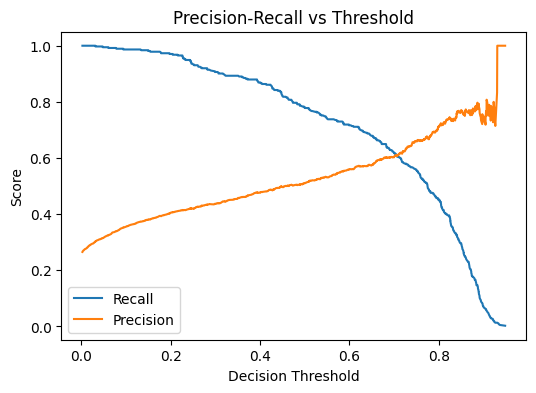

In [16]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(thresholds, recall[:-1], label="Recall")
plt.plot(thresholds, precision[:-1], label="Precision")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall vs Threshold")
plt.show()



### Custom Threshold for increasing recall

In [20]:
custom_threshold = 0.3

y_pred_custom = (y_prob >= custom_threshold).astype(int)

print(classification_report(y_test, y_pred_custom))
confusion_matrix(y_test, y_pred_custom)


              precision    recall  f1-score   support

           0       0.94      0.58      0.72      1035
           1       0.44      0.91      0.59       374

    accuracy                           0.67      1409
   macro avg       0.69      0.74      0.65      1409
weighted avg       0.81      0.67      0.68      1409



array([[598, 437],
       [ 35, 339]])

### Model Explainability

In [14]:
# Feature Importance
feature_names = final_model.named_steps["preprocessor"].get_feature_names_out()
coefficients = final_model.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

coef_df.head(10)


,Feature,Coefficient
9,cat__Dependents_No,0.703551
37,cat__Contract_Month-to-month,0.659744
17,cat__Internet Service_Fiber optic,0.592153
2,num__Total Charges,0.497394
44,cat__Payment Method_Electronic check,0.233431
36,cat__Streaming Movies_Yes,0.222129
33,cat__Streaming TV_Yes,0.210854
19,cat__Online Security_No,0.163354
28,cat__Tech Support_No,0.144783
15,cat__Multiple Lines_Yes,0.106668


In [15]:
coef_df.tail(10)

,Feature,Coefficient
20,cat__Online Security_No internet service,-0.256757
18,cat__Internet Service_No,-0.256757
32,cat__Streaming TV_No internet service,-0.256757
26,cat__Device Protection_No internet service,-0.256757
40,cat__Paperless Billing_No,-0.273858
1,num__Monthly Charges,-0.558089
16,cat__Internet Service_DSL,-0.562570
39,cat__Contract_Two year,-0.753216
10,cat__Dependents_Yes,-0.930725
0,num__Tenure Months,-1.192991


In [17]:
import joblib
joblib.dump(final_model, '../models/churn_prediction_pipeline.pkl')

['../models/churn_prediction_pipeline.pkl']

##  Model Evaluation & Business-Oriented Decision Making

### 1. Model Comparison Summary

Three supervised learning models were evaluated for the customer churn prediction task:

| Model | ROC AUC |
|------|--------|
| Logistic Regression | **0.84** |
| Random Forest | 0.83 |
| XGBoost | 0.82 |

Logistic Regression achieved the highest ROC AUC score, indicating the best overall ability to distinguish between churned and non-churned customers.

In addition to performance, Logistic Regression was selected due to:
- High interpretability
- Stable behavior with scaled features
- Clear coefficient-based explanations aligned with business needs

As a result, Logistic Regression was chosen as the final model.

---

### 2. Threshold Optimization Using Precision–Recall Trade-off

The default probability threshold (0.5) is not always optimal from a business perspective.

#### Business Objective
The primary goal is to **reduce customer churn**, which requires identifying as many churned customers as possible.  
Therefore, **Recall** is prioritized over Precision.

#### Methodology
- A Precision–Recall curve was analyzed across different probability thresholds
- Lower thresholds increase Recall while reducing Precision
- Based on the curve and business requirements, a custom threshold was selected

#### Final Threshold Selection
- **Chosen threshold: 0.3**
- This threshold significantly increases Recall, ensuring that most churned customers are detected and can be targeted by retention strategies

---

### 3. Model Explainability & Feature Importance

Logistic Regression provides transparent model explainability through feature coefficients.  
Positive coefficients increase churn probability, while negative coefficients decrease it.

---

### 🔺 Top Features Increasing Churn Probability (Positive Coefficients)

| Feature | Coefficient |
|-------|------------|
| `cat_Dependents_No` | 0.70 |
| `cat_Contract_Month-to-month` | 0.65 |
| `cat_Internet_service_Fiber optic` | 0.59 |

**Interpretation:**
- Customers without dependents are more likely to churn
- Month-to-month contracts strongly increase churn risk
- Fiber optic internet users exhibit higher churn probability, possibly due to pricing or service expectations

---

### 🔻 Top Features Reducing Churn Probability (Negative Coefficients)

| Feature | Coefficient |
|-------|------------|
| `cat_OnlineSecurity_No internet service` | -0.25 |
| `cat_InternetService_No` | -0.25 |
| `cat_StreamingTV_No internet service` | -0.25 |

**Interpretation:**
- Customers without internet-related services are less likely to churn
- These users may represent stable, low-risk customer segments

---

### 4. Business Insights & Actionable Recommendations

Based on the evaluation results:

- Prioritize retention efforts for:
  - Month-to-month contract customers
  - Customers without dependents
  - Fiber optic internet subscribers
- Introduce:
  - Long-term contract incentives
  - Targeted retention campaigns for high-risk users
- Deploy the model using a **0.3 probability threshold** to maximize churn detection

